# Lab03

## Neural Network Example
We are going to implement a Neural Network for identifying animal species using features of animals.

In [ ]:
import torch
import numpy as np

Let's say we have two features that represent the following two aspects: 
1. Does the animal have hair? 
2. Does the animal have feathers?



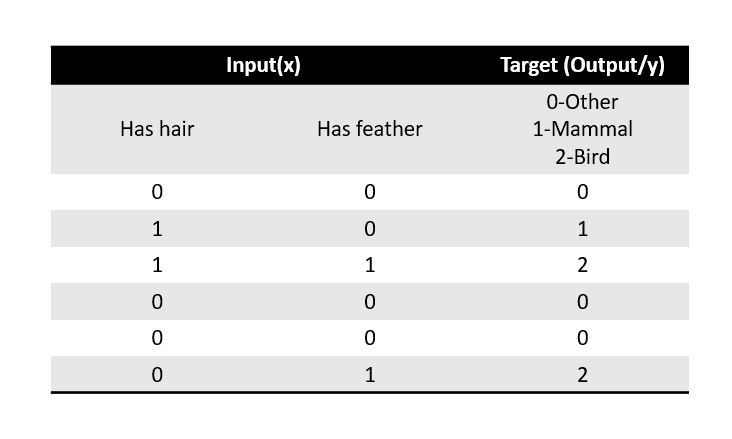

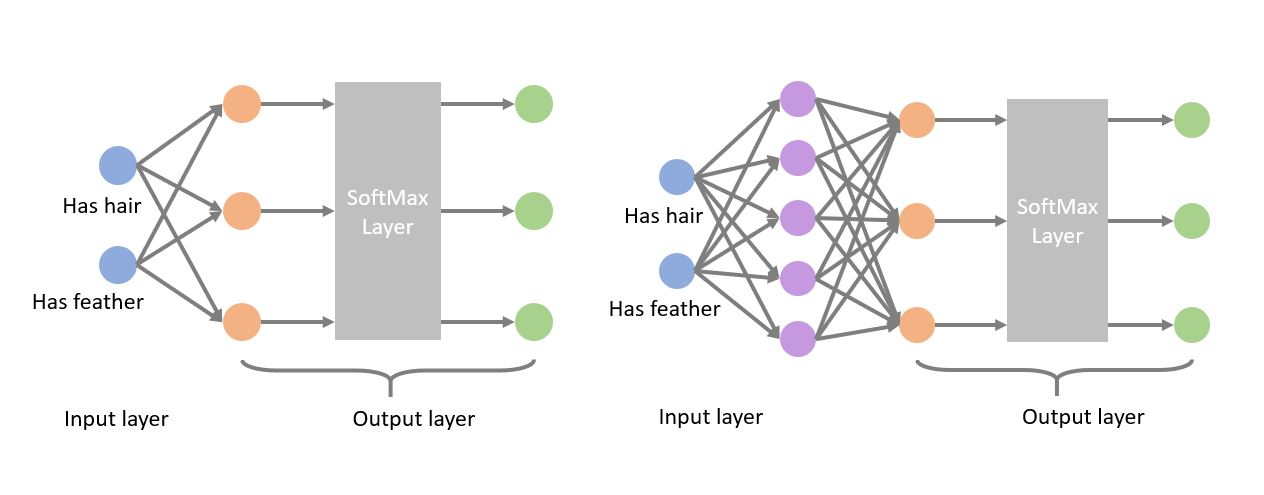

We would like to predict whether the animal is a bird, a mammal, or something else.

In [ ]:
# Create our feature data 
# [Hair, Feather]: 0 means doesn't have, 1 means have 
# e.g. [1, 0] indicates the animal has hair and doesn't have feathers
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# We need to transform the data into a Torch data type to be used in Pytorch
x_data_torch = torch.from_numpy(x_data).float() 
# Uncomment the following line if you want to see the details
# print(x_data_torch) 

# Create our target data
y_data = np.array([0,1,2,0,0,2]) # 0-Other  1-Mammal  2-Bird
y_data_torch = torch.from_numpy(y_data)
# Uncomment the following line if you want to see the details
# print(y_data_torch) 

# number of inputs (features), 2 - Hair, Feather
num_features = 2
# number of output (classes), 3 - Other, Mammal, Bird
num_classes = 3

### No hidden layer with Manual Parameter Update

Build a classification model without a hidden layer.
We manually update the parameters (weight and bias) in this example.

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Initialize Weight and Bias manually, and setup the gradient
# torch.randn returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 (also called the standard normal distribution)
W1 = torch.randn(num_features, num_classes, requires_grad=True)
B1 = torch.randn(num_classes, requires_grad=True)

# Learning Rate - determines the step size at each iteration while moving toward a minimum of a loss function
learning_rate=0.01

# Epoch - A measure of the number of times all of the training vectors are used once to update the weights.
number_of_epochs = 1000 # TODO: try 2000 epochs and see how it goes

for epoch in range(number_of_epochs): 

    # forward propagataion - the calculation and storage of intermediate variables (incl. outputs) from the input layer to the output layer
    z = torch.add(torch.matmul(x_data_torch, W1), B1)

    # softmax changes each value to be between 0 and 1, and all values will add up to 1. Can you see this is like a probability distribution?
    # i.e. [8.04, 2.76, -6.52] -> [0.53 0.24 0.23]
    # log_softmax applies logarithm after softmax.
    # softmax: exp(x_i) / exp(x).sum() and log_softmax: log( exp(x_i) / exp(x).sum() )
    # log_softmax essentially does log(softmax(x)), but the practical implementation is different and more efficient
    # https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax
    log_softmax = F.log_softmax(z, dim=1)

    # calculate the negative log likelihood loss
    loss = F.nll_loss(log_softmax, y_data_torch)

    # back propagation
    loss.backward()  #calculate gradient
    with torch.no_grad(): # When doing back propagation, do not accumulate gradient
        W1.data -= learning_rate*W1.grad.data #Gradient descent
        B1.data -= learning_rate*B1.grad.data
    W1.grad.data.zero_() # reset the gradient
    B1.grad.data.zero_()

    if epoch % 200 == 199: 
        with torch.no_grad(): # prediction section does not require gradient 
            pred_outputs = torch.add(torch.matmul(x_data_torch, W1), B1)
            predicted = torch.argmax(pred_outputs, 1)
            train_acc = accuracy_score(predicted.numpy(), y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss.item(), train_acc))

# Result
print('Predicted :', predicted.numpy())
print('Truth :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 0.6808, train_acc: 0.833
Epoch: 400, loss: 0.5637, train_acc: 0.833
Epoch: 600, loss: 0.4814, train_acc: 1.000
Epoch: 800, loss: 0.4186, train_acc: 1.000
Epoch: 1000, loss: 0.3690, train_acc: 1.000
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


### No hidden layer with the Optimiser


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Build a neural network model rather than initializing the parameters manually
# torch.nn.Linear applies a linear transformation to the input data: y = Ax + b
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
class ModelWithoutHiddenLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(ModelWithoutHiddenLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size) # This corresponds to W1,B1

    def forward(self, x):
        x = self.linear(x)
        return x

# Initialize the model
model = ModelWithoutHiddenLayer(num_features, num_classes)

# learning rate
learning_rate=0.01

# calculate negative log likelihood loss
criterion = nn.NLLLoss()

# Define the optimiser
# Pass the model parameters to be updated, and set up the learning rate when calling optim.SGD
# Please find detailed information about the SGD optimiser in PyTorch (https://pytorch.org/docs/stable/optim.html).
optimiser = optim.SGD(model.parameters(), lr = learning_rate) 

# For every epoch, the model weights will be modified using the given learning rate
no_of_epochs = 1000

for epoch in range(no_of_epochs):  

    # get the inputs and labels
    inputs = x_data_torch
    labels = y_data_torch

    # set the module in training mode (for illustration)
    # A module can be set to training mode (net.train(mode=True)) or evaluation mode (when net.train(mode=False) or net.eval())
    # This has an effect only on certain modules such as Dropout, BatchNorm etc.
    model.train() # mode = True by default

    # set the gradients to zero
    optimiser.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(F.log_softmax(outputs,dim=1), labels)
    loss.backward()
    optimiser.step() # back propagation

    if epoch % 200 == 199:    # print every 200 epochs
        model.eval() # we are using the model to predict here, i.e. set the module to evaluation mode
        pred_outputs = model(inputs)
        predicted = torch.argmax(pred_outputs, 1)
        train_acc = accuracy_score(predicted.numpy(),y_data)
        print('%d, loss: %.3f, train_acc: %.3f' %(epoch + 1, loss.item(), train_acc))

print('Finished Training')

# Result
model.eval()
pred_outputs = model(inputs)
predicted = torch.argmax(pred_outputs, 1)
print('Predicted :', predicted.numpy())
print('Truth :', y_data)

train_acc = accuracy_score(predicted.numpy(),y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.866, train_acc: 0.667
400, loss: 0.718, train_acc: 0.833
600, loss: 0.610, train_acc: 0.833
800, loss: 0.527, train_acc: 1.000
1000, loss: 0.462, train_acc: 1.000
Finished Training
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


### Hidden Layer with Manual Parameter Update

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# you can find the detailed comments and explanation in the section - no hidden layer with manual parameter update section 

# number of neurons in hidden layer, 
n_hidden_1 = 5

# [Input(Features), Output(number of neurons in hidden layer)]
W1 = torch.randn(num_features, n_hidden_1, requires_grad=True)

# Let Hidden Layer Bias dimension be the number of output candidates, which is 5 (number of neurons in hidden layer).
B1 = torch.randn(n_hidden_1, requires_grad=True)

# [Input(number of neurons in hidden layer), Output(Classes)]
Wout = torch.randn(n_hidden_1, num_classes, requires_grad=True)

# Let Bias have dimension equal to the number of output candidates, which is 3 (number of classes).
Bout = torch.randn(num_classes, requires_grad=True)

learning_rate=0.01
no_of_epochs = 1000

for epoch in range(no_of_epochs):    
    z1 = torch.add(torch.matmul(x_data_torch, W1), B1)
    Zout = torch.add(torch.matmul(F.relu(z1), Wout), Bout)

    log_softmax = F.log_softmax(Zout,dim=1)
    loss = F.nll_loss(log_softmax, y_data_torch)

    loss.backward()
    with torch.no_grad():
        W1.data -= learning_rate*W1.grad.data
        B1.data -= learning_rate*B1.grad.data
        Wout.data -= learning_rate*Wout.grad.data
        Bout.data -= learning_rate*Bout.grad.data

    W1.grad.data.zero_()
    B1.grad.data.zero_()
    Wout.grad.data.zero_()
    Bout.grad.data.zero_()

    if epoch % 200 == 199: 
        with torch.no_grad():
            z1 = torch.add(torch.matmul(x_data_torch ,W1),B1)
            Zout = torch.add(torch.matmul(F.relu(z1) ,Wout),Bout)
            predicted = torch.argmax(Zout, 1)
            train_acc = accuracy_score(predicted.numpy(),y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss.item() , train_acc))
print("Finished")
# Result
print('Predicted :', predicted.numpy())
print('Truth :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 0.7475, train_acc: 0.500
Epoch: 400, loss: 0.4992, train_acc: 1.000
Epoch: 600, loss: 0.3446, train_acc: 1.000
Epoch: 800, loss: 0.2451, train_acc: 1.000
Epoch: 1000, loss: 0.1732, train_acc: 1.000
Finished
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


### Hidden Layer with the Optimiser


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#you can find detailed comments and explanation in the section - no hidden layer with the optimiser section 

class ModelWithHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ModelWithHiddenLayer, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        z1 = self.linear1(x)
        Zout = self.linear2(F.relu(z1))
        return Zout

model = ModelWithHiddenLayer(num_features, n_hidden_1, num_classes)

learning_rate = 0.01
no_of_epochs = 1000

# If you apply Pytorch’s CrossEntropyLoss to your output layer,
# you get the same result as applying Pytorch’s NLLLoss to a LogSoftmax layer added after your original output layer.
criterion = nn.CrossEntropyLoss() 
optimiser = optim.SGD(model.parameters(), lr=learning_rate)

from sklearn.metrics import accuracy_score

for epoch in range(no_of_epochs):  # loop over the dataset multiple times

    # get the inputs
    inputs = x_data_torch
    labels = y_data_torch

    model.train()
    # zero the parameter gradients
    optimiser.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels) # We don't need to calculate logsoftmax here
    loss.backward()
    optimiser.step()

    # print statistics
    if epoch % 200 == 199:    # print every 200 epochs
        model.eval()
        pred_outputs = model(inputs)
        predicted = torch.argmax(pred_outputs, 1)
        train_acc = accuracy_score(predicted.numpy(),y_data)
        print('%d, loss: %.4f, train_acc: %.4f' %(epoch + 1, loss.item(), train_acc))

print('Finished Training')

# Result
pred_outputs = model(inputs)
_, predicted = torch.max(pred_outputs, 1)
print('Predicted :', predicted.numpy())
print('Truth :', y_data)

train_acc = accuracy_score(predicted.numpy(),y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.9878, train_acc: 0.5000
400, loss: 0.9072, train_acc: 0.5000
600, loss: 0.8236, train_acc: 0.5000
800, loss: 0.7258, train_acc: 0.6667
1000, loss: 0.6158, train_acc: 0.6667
Finished Training
Predicted : [0 2 2 0 0 0]
Truth : [0 1 2 0 0 2]
Accuracy : 0.67


## Word2Vec on Pytorch
Let's try to implement Word2Vec - Skip Gram with a Neural Network via Pytorch

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Raw data - sentences
# Let's create some toy data for simplicity 
sentences = ["he likes cat",
             "he likes dog",
             "he likes animal",
             "dog cat animal",
             "she likes cat",
             "she dislikes dog",
             "cat likes fish",
             "cat likes milk",
             "dog likes bone",
             "dog dislikes fish",
             "dog likes milk",
             "she likes movie",
             "she likes music",
             "he likes game",
             "he likes movie",
             "cat dislikes dog"]

# extract the unique word list from the sentences
word_list = " ".join(sentences).split()
word_list = list(set(word_list))

# make a dictionary so that we can reference the index of each unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# make window size = 1 for skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for sentence in sentences:
    sentence = sentence.split()
    for i in range(len(sentence)):
        centre = word_dict[sentence[i]]
        if i > 0 and i < len(sentence)-1:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i + 1]]]
        elif i == 0:
            context = [word_dict[sentence[i + 1]]]
        else:
            context = [word_dict[sentence[i - 1]]]

        # skipgrams - (centre, context[0]), (centre, context[1])..
        for w in context:
            skip_grams.append([centre, w])

In [ ]:
voc_size = len(word_list)

# prepare batch from skip-gram
def prepare_batch(data_temp):
    inputs = []
    labels = []

    for i in range(len(data_temp)):
        input_temp = [0]*voc_size
        input_temp[data_temp[i][0]] = 1 # ont-hot input
        inputs.append(input_temp)  # centre
        labels.append(data_temp[i][1])  # context word

    return np.array(inputs), np.array(labels)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from random import shuffle

batch_size = 16
learning_rate = 0.1
embedding_size = 2
no_of_epochs = 5000

# randomly initialise the weight vectors. Note there is no bias in word2vec
W1 = torch.randn(voc_size, embedding_size, requires_grad=True)
Wout = torch.randn(embedding_size, voc_size, requires_grad=True)

for epoch in range(no_of_epochs):

    # shuffle the training set to make each epoch's batch different, you can also skip this step
    shuffle(skip_grams)
    loss_sum = 0

    for ind in range(0,len(skip_grams),batch_size):
        data_temp = skip_grams[ind : min(ind+batch_size, len(skip_grams))]
        inputs_temp, labels_temp = prepare_batch(data_temp)
   
        inputs_torch = torch.from_numpy(inputs_temp).float()
        labels_torch = torch.from_numpy(labels_temp)

        hidden = torch.matmul(inputs_torch ,W1)
        out = torch.matmul(hidden,Wout)

        log_softmax = F.log_softmax(out, dim=1)
        loss = F.nll_loss(log_softmax, labels_torch)

        loss.backward()
        with torch.no_grad():
            W1.data -= learning_rate * W1.grad.data
            Wout.data -= learning_rate * Wout.grad.data
        W1.grad.data.zero_()
        Wout.grad.data.zero_()

        loss_sum += loss.item()

    if epoch % 500 == 499: 
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss_sum))


Epoch: 500, loss: 5.5589
Epoch: 1000, loss: 5.4835
Epoch: 1500, loss: 5.4905
Epoch: 2000, loss: 5.4412
Epoch: 2500, loss: 5.4492
Epoch: 3000, loss: 5.4342
Epoch: 3500, loss: 5.4473
Epoch: 4000, loss: 5.4981
Epoch: 4500, loss: 5.4594
Epoch: 5000, loss: 5.4409


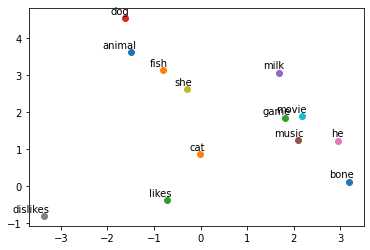

In [ ]:
# Get the trained projection matrix
trained_embeddings = W1.data.numpy()
# Visualise result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, " : ", x, " " , y) # uncomment to see the detailed vector info
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

# Exercise





##E1. Briefly describe the difference between intrinsic and extrinsic word vector evaluation. (Full Mark: 1 mark. There is no partial mark.)

In order to receive full marks, please write down your answer below with **supportive examples**, using your own words.

Answer: Refer to Lecture 3 slides (and the corresponding recording), from page 8.

##E2. Word2Vec Playground  (Full Mark: 1 mark. There is no partial mark.) 


Let's review what we've practised for Word2Vec embedding so far:


*   Word2Vec (CBOW/Skip-Gram) training with Gensim and word embedding extraction. (in Lab 2) 
*   Word2Vec (Skip-Gram) training from scratch with Pytorch, word embedding extraction, and word embedding visualization. (in Lab 3)

In this E2 (Exercise2), let's get more familiar with both Word2Vec implementation with Gensim and with Pytorch from scratch, and compare the difference.





Please complete the following steps:

Step 0.  Use the **training corpus we provide** to train the following two Word2Vec models:

Step 1.  Use **Gensim** to train a Word2Vec **Skip-Gram** Model. (like in Lab2)

Step 2.  Use **Pytorch** to train a Word2Vec **Skip-Gram** Model. (like in Lab3)

Step 3.  Visualize the derived word embedding for **both Model 1 (Gensim - Lab2) and Model 2 (Pytorch - Lab3) above**.

**Note:** 
- Apply **window_size = 2**, **word embedding dimension = 2** for both Model 1 and Model 2 above.






### 0.Training Corpus

In [ ]:
## Train your models using the following corpus:
corpus = ["he likes cat and cat",
             "he likes dog and cat",
             "he really likes animal",
             "dog and cat are animal",
             "she likes cat and dog",
             "she dislikes dog and cat",
             "cat really likes fish",
             "cat likes milk and fish",
             "dog likes bone but dislikes fish",
             "dog dislikes fish but likes bone",
             "dog likes milk and bone",
             "she likes movie and music",
             "she likes music and movie",
             "he likes game and music",
             "he likes movie and dog",
             "cat dislikes dog but likes fish"]


**NOTE: **
*   Write your code using the following sections. 
*   Import all the libraries needed and make sure your code runs successfully
*   Put the proper comments to make your code understandable :D



### 1.Gensim Word2Vec Skip-Gram Model (Window Size = 2, word embedding dimension = 2)

In [ ]:
# Train the Gensim Skip-Gram model and please set appropriate hyperparameters.
# You are free to create and use multiple code cells based on your needs
# You can also create subsections under the sections we provided based on your needs

# Remember to use window size=2 for skip-gram
# i.e.) he likes cat and dog
#   -> (he, [likes, cat]), (likes,[he, cat, and]), (cat,[he, likes, and, dog]), (and, [likes, cat, dog]),(dog, [cat, and])
#   -> (he, likes), (he, cat), (likes, he), (likes, cat), (likes, and), (cat, he), (cat, likes), (cat, and), (cat, dog) ......




### 2.Word2Vec from Scratch with Pytorch (Window Size = 2, word embedding dimension = 2)

In [ ]:
# Train the Pytorch Skip-Gram model and please set appropriate hyperparameters.
# You are free to create and use multiple code cells based on your needs
# You can also create subsections under the sections we provided based on your needs

# Remember to use window size=2 for skip-gram
# i.e.) he likes cat and dog
#   -> (he, [likes, cat]), (likes,[he, cat, and]), (cat,[he, likes, and, dog]), (and, [likes, cat, dog]),(dog, [cat, and])
#   -> (he, likes), (he, cat), (likes, he), (likes, cat), (likes, and), (cat, he), (cat, likes), (cat, and), (cat, dog) ......



###3. Word Embedding Extraction and Visualization

In [ ]:
# For Gensim Skip-Gram model (from the step 1):
# Extract and visualize the 2-dimensional word embeddings (i.e. from the trained projection layer matrix).
# You are free to create and use multiple code cells based on your needs
# You can also create subsections under the sections we provided based on your needs

# An example output can be found in the log below (only for the embeeding visualization format reference)



In [ ]:
# For PyTorch Skip-Gram model (from the step 2):
# Extract and visualize the 2-dimensional word embeddings (i.e. from the trained projection layer matrix).
# You are free to create and use multiple code cells based on your needs
# You can also create subsections under the sections we provided based on your needs

# An example output can be found in the log below (only for the embedding visualization format reference)




**E2 Sample output**

The following is **the sample output (only for the embedding visualisation format reference) for E2**

**An example visualisation output with Gensim Skip-Gram model**

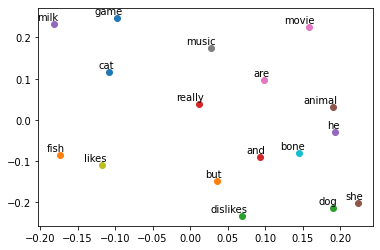

**An example visualisation output with Pytorch Skip-Gram model**


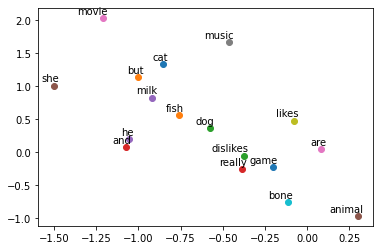

## Sample Solutions

### 0.Training Corpus

In [ ]:
## Train the models using the following corpus provided.
corpus = ["he likes cat and dog",
             "he likes dog and cat",
             "he really likes animal",
             "dog and cat are animal",
             "she likes cat and dog",
             "she dislikes dog and cat",
             "cat really likes fish",
             "cat likes milk and fish",
             "dog likes bone but dislikes fish",
             "dog dislikes fish but likes bone",
             "dog likes milk and bone",
             "she likes movie and music",
             "she likes music and movie",
             "he likes game and music",
             "he likes movie and dog",
             "cat dislikes dog but likes fish"]


### 1.Gensim Word2Vec Skip-Gram Model (Window Size = 2, word embedding dimension = 2)

In [ ]:
# Import libraries
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Prepare training corpus for Gensim Word2Vec Skip-Gram model - List of List
sentences=[]
sentences=[word_tokenize(sentence) for sentence in corpus]

In [ ]:
# Get the unique word list (i.e. vocab)
word_list = " ".join(corpus).split()
word_list = list(set(word_list))
print(len(word_list))

17


In [ ]:
# Train the Gensim Word2Vec Skip-Gram model
gensim_model = Word2Vec(sentences=sentences, size=2, window=2, min_count=1, workers=2, sg=1)

### 2.Word2Vec from Scratch with Pytorch (Window Size = 2, word embedding dimension = 2)

In [ ]:
# make dictionary so that we can reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}


# make window size=2 for skip-gram
# i.e.) he likes cat and dog
#   -> (he, [likes, cat]), (likes,[he, cat, and]), (cat,[he, likes, and, dog]), (and, [likes, cat, dog]),(dog, [cat, and])
#   -> (he, likes), (he, cat), (likes, he), (likes, cat), (likes, and), (cat, he), (cat, likes), (cat, and), (cat, dog) ......

skip_grams = []

for sentence in corpus:
    sentence=sentence.split()
    for i in range(len(sentence)):
        centre = word_dict[sentence[i]]
        if i > 1 and i < len(sentence)-2:
            context = [word_dict[sentence[i - 2]],word_dict[sentence[i - 1]],word_dict[sentence[i + 1]],word_dict[sentence[i + 2]]]
        elif i == 0:
            context = [word_dict[sentence[i + 1]],word_dict[sentence[i + 2]]]
        elif i == 1:
            context = [word_dict[sentence[i - 1]],word_dict[sentence[i + 1]],word_dict[sentence[i + 2]]]         
        elif i == len(sentence)-2:
            context = [word_dict[sentence[i - 2]],word_dict[sentence[i - 1]],word_dict[sentence[i + 1]]]
        else:
            context = [word_dict[sentence[i - 2]],word_dict[sentence[i - 1]]]
        for w in context:
            skip_grams.append([centre, w])

In [ ]:
voc_size = len(word_list)
# prepare batch from skip-gram
def prepare_batch(data_temp):
    inputs = []
    labels = []

    for i in range(len(data_temp)):
        input_temp = [0]*voc_size
        input_temp[data_temp[i][0]] = 1 # ont-hot input
        inputs.append(input_temp)  # centre
        labels.append(data_temp[i][1])  # context word

    return np.array(inputs), np.array(labels)

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from random import shuffle
import numpy as np

# set hyperparameters
batch_size = 16
learning_rate = 0.001
embedding_size = 2
no_of_epochs = 5000

W1 = torch.randn(voc_size, embedding_size, requires_grad=True)
Wout = torch.randn(embedding_size, voc_size, requires_grad=True)

for epoch in range(no_of_epochs):

    # shuffle the training set to make each epoch's batch different, you can also skip this step
    shuffle(skip_grams)
    loss_sum = 0

    for ind in range(0,len(skip_grams),batch_size):
        data_temp = skip_grams[ind : min(ind+batch_size, len(skip_grams))]
        inputs_temp, labels_temp = prepare_batch(data_temp)
   
        inputs_torch = torch.from_numpy(inputs_temp).float()
        labels_torch = torch.from_numpy(labels_temp)

        hidden = torch.matmul(inputs_torch ,W1)
        out = torch.matmul(hidden,Wout)

        log_softmax = F.log_softmax(out,dim=1)
        loss = F.nll_loss(log_softmax, labels_torch)

        loss.backward()
        with torch.no_grad():
            W1.data -= learning_rate*W1.grad.data
            Wout.data -= learning_rate*Wout.grad.data
        W1.grad.data.zero_()
        Wout.grad.data.zero_()

        loss_sum += loss.item()

    if epoch % 500 == 499: 
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss_sum))


Epoch: 500, loss: 45.1600
Epoch: 1000, loss: 42.0483
Epoch: 1500, loss: 40.9485
Epoch: 2000, loss: 39.9472
Epoch: 2500, loss: 39.4264
Epoch: 3000, loss: 39.3895
Epoch: 3500, loss: 38.3778
Epoch: 4000, loss: 38.4914
Epoch: 4500, loss: 38.0410
Epoch: 5000, loss: 37.6342


###3. Word Embedding Extraction and Visualization

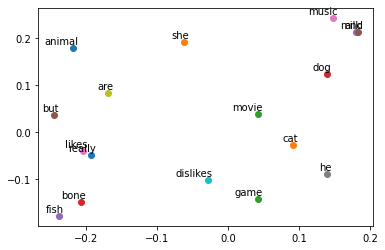

In [ ]:
# Word embedding extraction and visualization for Gensim Skip-Gram model (from the step 1):
import matplotlib.pyplot as plt
for i, word in enumerate(word_list):
    x, y = gensim_model.wv[word]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

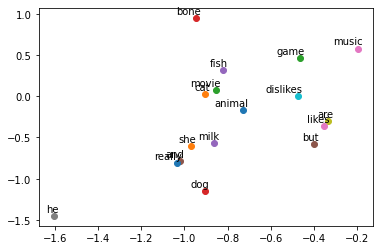

In [ ]:
# Word embedding extraction and visualization for PyTorch Skip-Gram model (from the step 2):
# Get the trained projection matrix
trained_embeddings = W1.data.numpy()
# Visualise result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, " : ", x, " " , y) # uncomment to see the detailed vector info
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()